In [ ]:
# basic imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from datetime import datetime
%matplotlib inline

# data processing 
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# get predictions from the best perfomming model
from sklearn.metrics import accuracy_score , confusion_matrix , f1_score ,roc_auc_score
from sklearn.metrics import precision_score , recall_score , roc_curve


# text processing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# deep learning libraries
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, Masking

In [ ]:
# function to draw graph results for the model
def plot_performance(history , Model_name):
    fig , ax = plt.subplots(1,2 , figsize =(12 ,6))
    ax[0].set_title(f"Accuracy Perfomance Analysis for {Model_name}" , c='red')
    ax[1].set_title(f"Loss Perfomance Analysis for {Model_name}" , c='red')
    ax[0].plot(history.history['acc'] , label ='train accuracy' , c='g')
    ax[0].plot(history.history['val_acc'] , label ='val accuracy' , c='orange')
    ax[1].set_ylabel('Accuracy' , fontsize =15)
    ax[1].set_xlabel('epochs' , fontsize =15)
    ax[1].plot(history.history['loss'] , label ='train loss' , c ='yellow')
    ax[1].plot(history.history['val_loss'] , label ='val loss' , c ='red')
    ax[1].set_ylabel('Loss' , fontsize =15)
    ax[1].set_xlabel('epoch' , fontsize =15)
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')

In [ ]:
def evaluate_model_perfomance(model_name, type):
    if type == "BLSTM":
      preds_probs = model_name.predict(testing_padded)[: , 0]
    else:
      preds_probs = model_name.predict(testing_padded)[: , 1]
    #evaluate the real class labels
    preds_labels= [1 if x>=0.45 else 0 for x in preds_probs]

    actual_labels =y_test
    print(f"\n*****Evaluating {type} Models Score using various metrics************\n")
    print(f"\t\tAccuracy is  {accuracy_score(actual_labels , preds_labels)}")
    print(f"\t\tPrecision Score is  {precision_score(actual_labels , preds_labels)}")
    print(f"\t\tRecall Score is  {recall_score(actual_labels , preds_labels)}")
    print(f"\t\tF1 Score is  {f1_score(actual_labels , preds_labels)}\n\n\n")


    # draw confusion matrix to show results
    c_matrix1 = confusion_matrix(actual_labels , preds_labels)
    sns.heatmap(c_matrix1 , annot= True , annot_kws={"size": 10} ,fmt="")
    plt.title("Confusion matrix")
    plt.xlabel("Actual Label")
    plt.ylabel("Predicted Label")

# Retrieving the dataset and converting it to a dataframe

Label 0 represents ham and label 1 represents spam. We have a total of 3672  messages and 3531 uniques messages which means, we have some repeated messages.

In [ ]:
url = 'https://raw.githubusercontent.com/Taiga83/Spam-Detection-Project/main/spam_ham_dataset'
messages = pd.read_csv(url, sep='\t', names=['Message','Label'])
messages.groupby('Label').describe() #provides a summary statistics

Message                                                               
        count unique                                                top freq
Label                                                                       
0        3672   3531  Subject: calpine daily gas nomination\n>\nrick...   20
1        1499   1462                                        Subject: \n   16

In [ ]:
print(messages)

                                                     Message  Label
605  ham   Subject: enron methanol ; meter # : 988291\nth...      0
2349 ham   Subject: hpl nom for january 9 , 2001\n( see a...      0
3624 ham   Subject: neon retreat\nho ho ho , we ' re arou...      0
4685 spam  Subject: photoshop , windows , office . cheap ...      1
2030 ham   Subject: re : indian springs\nthis deal is to ...      0
...                                                      ...    ...
1518 ham   Subject: put the 10 on the ft\nthe transport v...      0
404  ham   Subject: 3 / 4 / 2000 and following noms\nhpl ...      0
2933 ham   Subject: calpine daily gas nomination\n>\n>\nj...      0
1409 ham   Subject: industrial worksheets for august 2000...      0
4807 spam  Subject: important online banking alert\ndear ...      1

[5171 rows x 2 columns]


# Ham Wordcloud

We use wordcloud to generate the words commonly used in ham and spam messages.

In [ ]:
# Get all the ham and spam text

ham = messages[messages.Label ==0]

spam = messages[messages.Label ==1]
# Convert to string
ham_string = " ".join(ham.Message.to_numpy().tolist())
spam_string = " ".join(spam.Message.to_numpy().tolist())


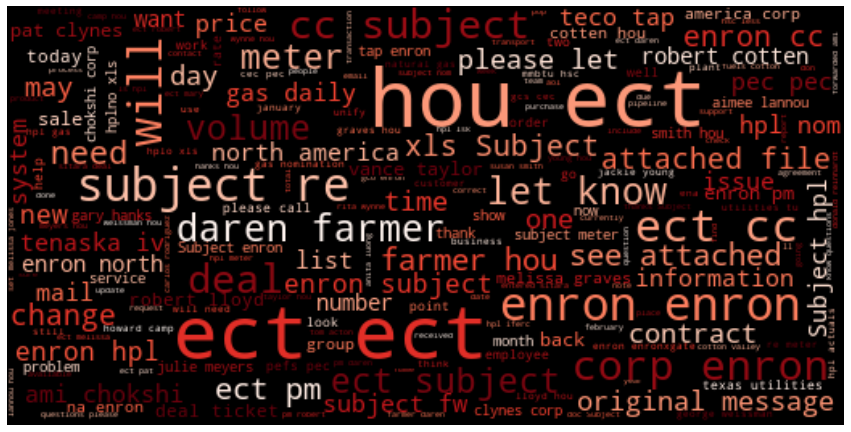

In [ ]:
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Reds').generate(str(ham_string))
plt.figure(figsize=(15,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')#
plt.axis('off')
plt.show()

#Spam Worcloud

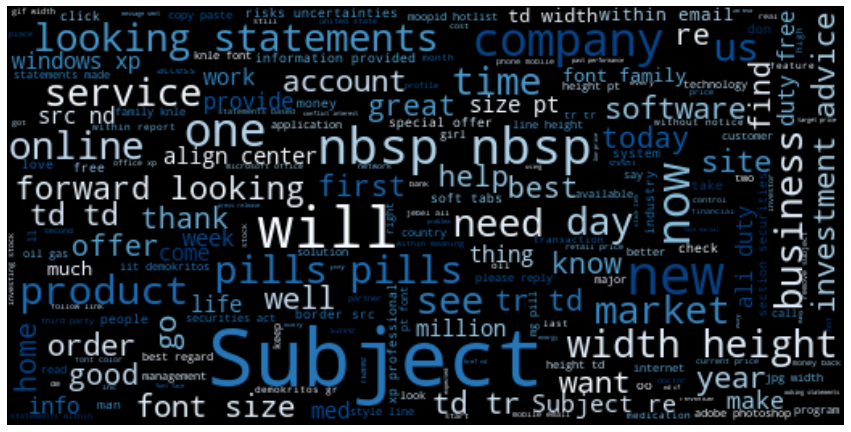

In [ ]:
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_string)
plt.figure(figsize=(15,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

# Data split between ham and spam

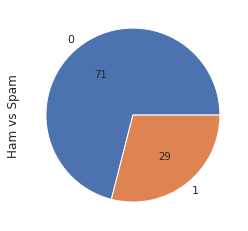

In [ ]:
messages.groupby('Label').size().plot(kind='pie', y='Label', label='Ham vs Spam', autopct='%.0f')

# Downsampling

In [ ]:
now = datetime.now()
ham_rebalanced = resample(ham, replace=True, n_samples=len(spam), random_state=now.hour + now.minute + now.second) 
print(ham_rebalanced.shape)
print(spam.shape)

(1499, 2)
(1499, 2)


In [ ]:
frames = [ham_rebalanced, spam]
combined_df = pd.concat(frames)
lengths = combined_df['Message'].apply(len)
avg_len = int(lengths.mean())
print(combined_df.describe())
print(f'{avg_len} characters')

             Label
count  2998.000000
mean      0.500000
std       0.500083
min       0.000000
25%       0.000000
50%       0.500000
75%       1.000000
max       1.000000
1075 characters


# Vectorization and split

In [ ]:
now = datetime.now()
combined_df['nLabel'] = combined_df['Label'].map({1:0, 0:1})
x_train, x_test, y_train, y_test = train_test_split(combined_df['Message'], combined_df['nLabel'], test_size=0.2, random_state=now.hour + now.minute + now.second)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25, random_state=now.hour + now.minute + now.second)

In [ ]:
print(f'{(x_train.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for training')
print(f'{(x_test.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for testing')
print(f'{(x_val.shape[0]/(x_val.shape[0]+ x_test.shape[0] + x_train.shape[0]))*100}% of the dataset is being used for validation')

59.97331554369579% of the dataset is being used for training
20.0133422281521% of the dataset is being used for testing
20.0133422281521% of the dataset is being used for validation


In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1798,)
(600,)
(600,)


Vectorizing

In [ ]:
max_vocab = 1000
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab)
vectorize_layer.adapt(combined_df['Message'].to_numpy())

#  Model Training and evaluation

Use of Dense architecture to train the model

In [ ]:

vocab_size = max_vocab
embedding_dim = 16
drop_value = 0.2 
n_dense = 24

In [ ]:
model = tf.keras.models.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.Masking(mask_value=0),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(n_dense, activation='relu'),
    tf.keras.layers.Dropout(drop_value),
    tf.keras.layers.Dense(1, activation='sigmoid')                     
])

model.summary()#output layer, shape and number of paramters in each layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 16)          16000     
                                                                 
 masking (Masking)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])
num_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x=x_train, y=y_train, epochs=num_epochs, validation_data=(x_val, y_val),callbacks=[early_stop], verbose=2)

Epoch 1/100
57/57 - 4s - loss: 0.6929 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.4933 - 4s/epoch - 70ms/step
Epoch 2/100
57/57 - 1s - loss: 0.6922 - accuracy: 0.5306 - val_loss: 0.6930 - val_accuracy: 0.5067 - 1s/epoch - 19ms/step
Epoch 3/100
57/57 - 1s - loss: 0.6921 - accuracy: 0.5367 - val_loss: 0.6926 - val_accuracy: 0.5083 - 753ms/epoch - 13ms/step
Epoch 4/100
57/57 - 1s - loss: 0.6916 - accuracy: 0.5451 - val_loss: 0.6921 - val_accuracy: 0.5167 - 604ms/epoch - 11ms/step
Epoch 5/100
57/57 - 1s - loss: 0.6911 - accuracy: 0.5634 - val_loss: 0.6910 - val_accuracy: 0.5383 - 555ms/epoch - 10ms/step
Epoch 6/100
57/57 - 1s - loss: 0.6903 - accuracy: 0.5712 - val_loss: 0.6903 - val_accuracy: 0.5433 - 569ms/epoch - 10ms/step
Epoch 7/100
57/57 - 1s - loss: 0.6895 - accuracy: 0.5851 - val_loss: 0.6892 - val_accuracy: 0.5633 - 572ms/epoch - 10ms/step
Epoch 8/100
57/57 - 1s - loss: 0.6879 - accuracy: 0.6046 - val_loss: 0.6880 - val_accuracy: 0.5783 - 551ms/epoch - 10ms/step
Epoch 

model results: training loss = 0.33, training accuracy = 93%, validation loss = 0.34, validation accuracy = 95%.

In [ ]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

In [ ]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

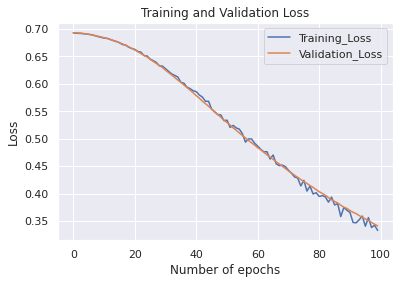

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'Loss')

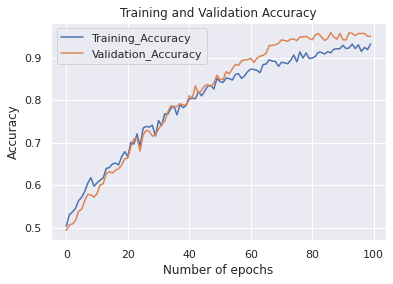

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'Accuracy')

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0) 
print(score[0])
print(score[1])

0.3512979745864868
0.949999988079071


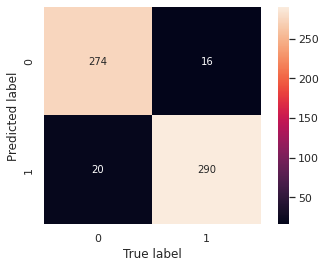

In [ ]:
plt.figure()
prediction = model.predict(x_test)
pred_label = [1 if x>= 0.45 else 0 for x in prediction]
mat = confusion_matrix(y_test, pred_label)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()